# 第5章：损失函数与优化器

> **学习目标：**
> - 理解不同损失函数的设计原理和适用场景
> - 掌握梯度下降的各种优化变体
> - 理解动量、自适应学习率的作用
> - 学会选择合适的优化器和学习率策略
>
> **学习时间：** 3-4小时

---

## 📚 为什么需要学习损失函数和优化器？

### 训练的本质

神经网络的训练可以抽象为一个优化问题：

$$\min_{\theta} L(\theta) = \min_{\theta} \frac{1}{m} \sum_{i=1}^{m} \ell(f_{\theta}(x^{(i)}), y^{(i)})$$

其中：
- $\theta$：模型参数（权重和偏置）
- $L(\theta)$：总体损失函数
- $\ell(\hat{y}, y)$：单样本损失函数
- $f_{\theta}(x)$：神经网络的前向传播

**📖 符号读法速查：**

| 符号 | 读法 | 含义 |
|------|------|------|
| $\theta$ | theta（西塔） | 模型参数（权重和偏置） |
| $L(\theta)$ | L of theta | 总体损失函数 |
| $\ell(\hat{y}, y)$ | ell / loss | 单样本损失函数 |
| $f_{\theta}(x)$ | f theta of x | 神经网络的前向传播 |
| $\hat{y}$ | y-hat（y帽） | 预测值 |
| $y$ | y | 真实值/标签 |
| $x$ | x | 输入特征 |
| $\alpha$ | alpha（阿尔法） | 学习率 |
| $\beta$ | beta（贝塔） | 动量系数 |
| $\epsilon$ | epsilon（艾普西隆） | 很小的常数 |
| $\nabla$ | nabla / gradient | 梯度算子 |
| $\partial$ | partial | 偏导数 |
| $\sum$ | sigma（求和） | 求和符号 |
| $\sigma$ | sigma（小写） | Sigmoid函数 |
| $\lambda$ | lambda（兰姆达） | 正则化系数 |

### 两个核心问题

1. **损失函数（Loss Function）**：如何量化预测误差？
   - 回归问题：MSE、MAE、Huber Loss
   - 分类问题：交叉熵、Hinge Loss
   - 不同损失函数的梯度性质影响训练效果

2. **优化器（Optimizer）**：如何高效地找到最优参数？
   - 基础：批量梯度下降（BGD）、随机梯度下降（SGD）、Mini-batch GD
   - 动量方法：Momentum、Nesterov Momentum
   - 自适应学习率：AdaGrad、RMSprop、Adam、AdamW

---

## 📖 目录

1. **损失函数详解**
   - 回归损失：MSE、MAE、Huber Loss
   - 分类损失：交叉熵、Hinge Loss
   - 损失函数的性质对比

2. **梯度下降的变体**
   - BGD vs SGD vs Mini-batch GD
   - 收敛速度对比

3. **动量方法**
   - 为什么需要动量？
   - Momentum和Nesterov Momentum
   - 可视化动量的效果

4. **自适应学习率优化器**
   - AdaGrad、RMSprop、Adam
   - Adam的完整推导
   - 优化器选择指南

5. **学习率调度**
   - 固定学习率 vs 衰减策略
   - Step Decay、Exponential Decay、Cosine Annealing
   - Warmup策略

6. **综合实战**
   - MNIST手写数字分类
   - 对比不同优化器的训练效果

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')


# 设置随机种子，确保结果可复现
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 设置随机种子
np.random.seed(42)

print("环境配置完成！")

环境配置完成！


---

## 1. 损失函数详解

### 1.1 回归任务的损失函数

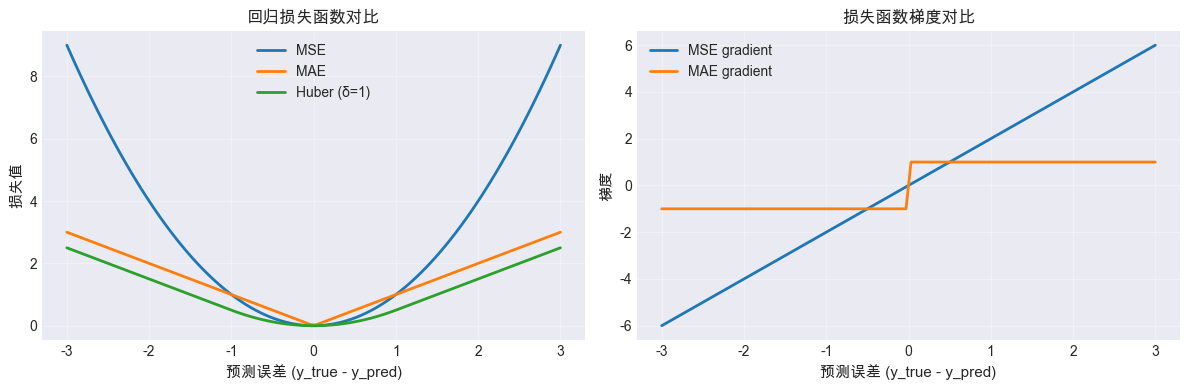


🔍 观察要点：
1. MSE对大误差惩罚更重（曲线更陡）
2. MAE的梯度恒定（±1），MSE的梯度随误差线性增长
3. Huber结合了两者优点：小误差时光滑，大误差时线性


In [2]:
def mse_loss(y_true, y_pred):
    """
    均方误差（Mean Squared Error）
    
    公式: MSE = (1/m) * Σ(y_true - y_pred)^2
    
    特点:
    - 对异常值敏感（因为平方项）
    - 梯度在误差较大时也较大，有助于快速收敛
    - 最常用的回归损失
    
    参数:
        y_true: 真实值, shape (m,)
        y_pred: 预测值, shape (m,)
    
    返回:
        loss: 标量损失值
    """
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_gradient(y_true, y_pred):
    """
    MSE损失的梯度
    
    公式: ∂MSE/∂y_pred = -2/m * (y_true - y_pred)
    
    返回:
        gradient: shape (m,)
    """
    return -2 * (y_true - y_pred) / len(y_true)


def mae_loss(y_true, y_pred):
    """
    平均绝对误差（Mean Absolute Error）
    
    公式: MAE = (1/m) * Σ|y_true - y_pred|
    
    特点:
    - 对异常值不敏感（鲁棒性强）
    - 梯度恒定，训练可能较慢
    - 适用于数据有噪声/异常值的场景
    
    参数:
        y_true: 真实值, shape (m,)
        y_pred: 预测值, shape (m,)
    
    返回:
        loss: 标量损失值
    """
    return np.mean(np.abs(y_true - y_pred))

def mae_loss_gradient(y_true, y_pred):
    """
    MAE损失的梯度
    
    公式: ∂MAE/∂y_pred = -sign(y_true - y_pred) / m
    
    返回:
        gradient: shape (m,)
    """
    return -np.sign(y_true - y_pred) / len(y_true)


def huber_loss(y_true, y_pred, delta=1.0):
    """
    Huber损失（结合MSE和MAE的优点）
    
    公式:
        Huber(e) = { 0.5 * e^2              if |e| <= δ
                   { δ * (|e| - 0.5 * δ)    if |e| > δ
    
    其中 e = y_true - y_pred
    
    特点:
    - 误差小时类似MSE（快速收敛）
    - 误差大时类似MAE（对异常值鲁棒）
    - 综合了两者的优点
    
    参数:
        y_true: 真实值, shape (m,)
        y_pred: 预测值, shape (m,)
        delta: 切换阈值，默认1.0
    
    返回:
        loss: 标量损失值
    """
    error = y_true - y_pred
    abs_error = np.abs(error)
    
    # 条件分支：小误差用MSE，大误差用MAE
    quadratic = np.where(abs_error <= delta, 
                         0.5 * error ** 2, 
                         delta * (abs_error - 0.5 * delta))
    
    return np.mean(quadratic)


# 可视化对比三种回归损失
errors = np.linspace(-3, 3, 100)
mse_values = [mse_loss(np.array([0]), np.array([e])) for e in errors]
mae_values = [mae_loss(np.array([0]), np.array([e])) for e in errors]
huber_values = [huber_loss(np.array([0]), np.array([e]), delta=1.0) for e in errors]

plt.figure(figsize=(12, 4))

# 损失函数对比
plt.subplot(1, 2, 1)
plt.plot(errors, mse_values, label='MSE', linewidth=2)
plt.plot(errors, mae_values, label='MAE', linewidth=2)
plt.plot(errors, huber_values, label='Huber (δ=1)', linewidth=2)
plt.xlabel('预测误差 (y_true - y_pred)', fontsize=11)
plt.ylabel('损失值', fontsize=11)
plt.title('回归损失函数对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 梯度对比
plt.subplot(1, 2, 2)
mse_grads = [mse_loss_gradient(np.array([0]), np.array([e]))[0] for e in errors]
mae_grads = [mae_loss_gradient(np.array([0]), np.array([e]))[0] for e in errors]
plt.plot(errors, mse_grads, label='MSE gradient', linewidth=2)
plt.plot(errors, mae_grads, label='MAE gradient', linewidth=2)
plt.xlabel('预测误差 (y_true - y_pred)', fontsize=11)
plt.ylabel('梯度', fontsize=11)
plt.title('损失函数梯度对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 观察要点：")
print("1. MSE对大误差惩罚更重（曲线更陡）")
print("2. MAE的梯度恒定（±1），MSE的梯度随误差线性增长")
print("3. Huber结合了两者优点：小误差时光滑，大误差时线性")

### 1.2 分类任务的损失函数

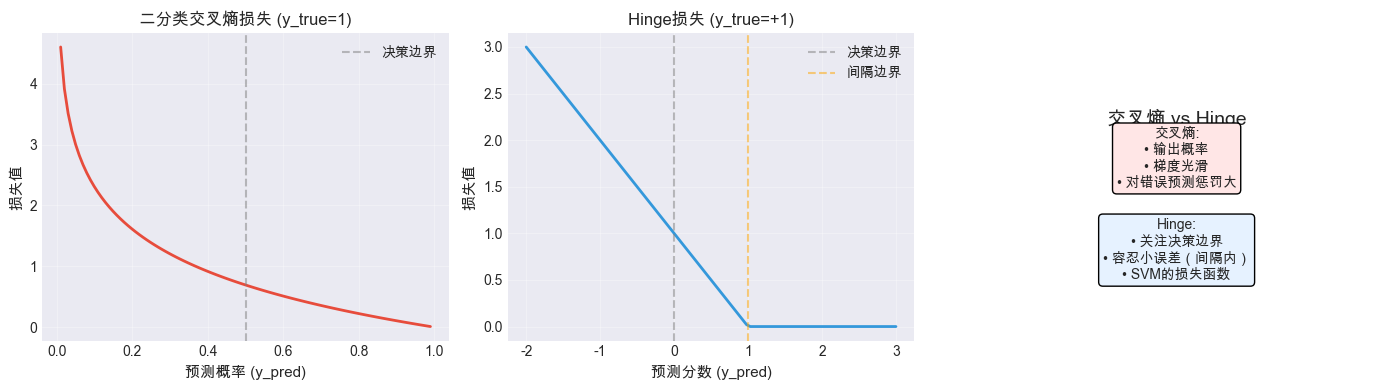


📌 损失函数选择指南：
回归任务：
  - MSE: 默认选择，适用于大多数场景
  - MAE: 数据有异常值时更鲁棒
  - Huber: 需要兼顾两者优点时

分类任务：
  - 交叉熵: 神经网络分类的标准损失
  - Hinge Loss: SVM或强调决策边界时


In [3]:
def binary_cross_entropy(y_true, y_pred, epsilon=1e-15):
    """
    二分类交叉熵损失
    
    公式: BCE = -1/m * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]
    
    参数:
        y_true: 真实标签（0或1）, shape (m,)
        y_pred: 预测概率（0到1之间）, shape (m,)
        epsilon: 防止log(0)的小常数
    
    返回:
        loss: 标量损失值
    """
    # 裁剪预测值，避免log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # 交叉熵公式
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return loss


def categorical_cross_entropy(y_true, y_pred, epsilon=1e-15):
    """
    多分类交叉熵损失
    
    公式: CCE = -1/m * Σ_i Σ_k y_{i,k} * log(ŷ_{i,k})
    
    参数:
        y_true: 真实标签（one-hot编码）, shape (m, n_classes)
        y_pred: 预测概率（softmax输出）, shape (m, n_classes)
        epsilon: 防止log(0)的小常数
    
    返回:
        loss: 标量损失值
    """
    # 裁剪预测值
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # 交叉熵公式
    loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    return loss


def hinge_loss(y_true, y_pred):
    """
    Hinge损失（用于SVM和二分类）
    
    公式: Hinge = 1/m * Σ max(0, 1 - y_true * y_pred)
    
    注意:
    - y_true应该是{-1, +1}而非{0, 1}
    - y_pred是未经过激活函数的原始分数
    
    参数:
        y_true: 真实标签（-1或+1）, shape (m,)
        y_pred: 预测分数（未激活）, shape (m,)
    
    返回:
        loss: 标量损失值
    """
    return np.mean(np.maximum(0, 1 - y_true * y_pred))


# 可视化二分类损失函数
# 假设真实标签 y_true = 1，横轴是预测值 y_pred
y_pred_range = np.linspace(0.01, 0.99, 100)

bce_values = [binary_cross_entropy(np.array([1]), np.array([p])) for p in y_pred_range]

# Hinge Loss（y_true=1，y_pred是分数而非概率）
y_score_range = np.linspace(-2, 3, 100)
hinge_values = [hinge_loss(np.array([1]), np.array([s])) for s in y_score_range]

plt.figure(figsize=(14, 4))

# 交叉熵损失
plt.subplot(1, 3, 1)
plt.plot(y_pred_range, bce_values, linewidth=2, color='#e74c3c')
plt.xlabel('预测概率 (y_pred)', fontsize=11)
plt.ylabel('损失值', fontsize=11)
plt.title('二分类交叉熵损失 (y_true=1)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='决策边界')
plt.legend()

# Hinge Loss
plt.subplot(1, 3, 2)
plt.plot(y_score_range, hinge_values, linewidth=2, color='#3498db')
plt.xlabel('预测分数 (y_pred)', fontsize=11)
plt.ylabel('损失值', fontsize=11)
plt.title('Hinge损失 (y_true=+1)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='决策边界')
plt.axvline(x=1, color='orange', linestyle='--', alpha=0.5, label='间隔边界')
plt.legend()

# 对比
plt.subplot(1, 3, 3)
plt.text(0.5, 0.7, '交叉熵 vs Hinge', ha='center', fontsize=14, fontweight='bold')
plt.text(0.5, 0.5, '交叉熵:\n• 输出概率\n• 梯度光滑\n• 对错误预测惩罚大', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='#ffe6e6'))
plt.text(0.5, 0.2, 'Hinge:\n• 关注决策边界\n• 容忍小误差（间隔内）\n• SVM的损失函数', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='#e6f2ff'))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n📌 损失函数选择指南：")
print("回归任务：")
print("  - MSE: 默认选择，适用于大多数场景")
print("  - MAE: 数据有异常值时更鲁棒")
print("  - Huber: 需要兼顾两者优点时")
print("\n分类任务：")
print("  - 交叉熵: 神经网络分类的标准损失")
print("  - Hinge Loss: SVM或强调决策边界时")

---

## 2. 梯度下降的变体

### 2.1 批量梯度下降 vs 随机梯度下降 vs Mini-batch

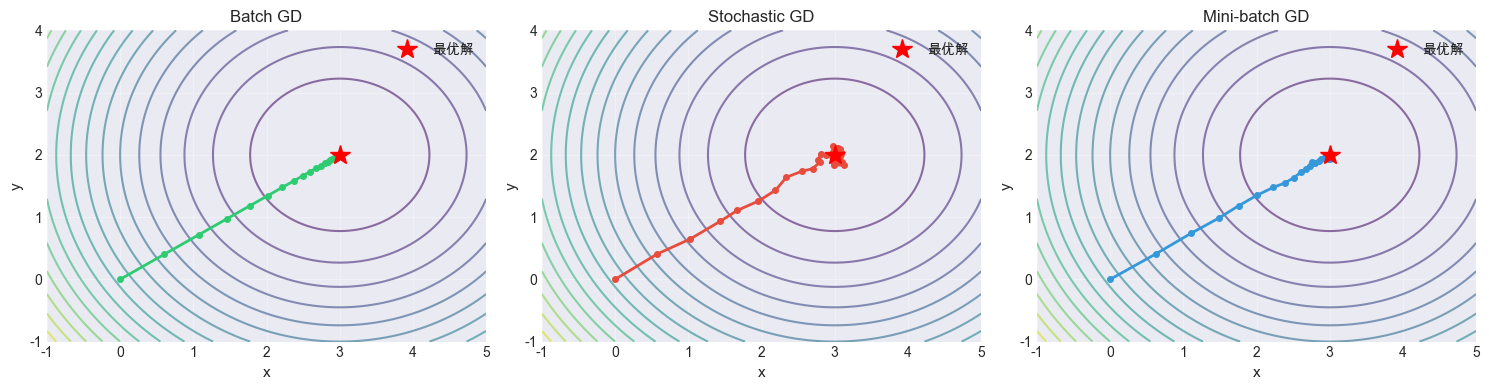


🔍 观察要点：
1. BGD：路径最平滑，直接指向最优解
2. SGD：路径震荡剧烈，但仍能收敛
3. Mini-batch：介于两者之间，实践中最常用


In [4]:
"""
梯度下降的三种变体：

1. 批量梯度下降（Batch Gradient Descent, BGD）
   - 每次迭代使用全部训练数据
   - 优点：收敛稳定，能找到全局最优（凸函数）
   - 缺点：计算慢，无法在线学习

2. 随机梯度下降（Stochastic Gradient Descent, SGD）
   - 每次迭代只用一个样本
   - 优点：速度快，可在线学习，能逃离局部最优
   - 缺点：收敛不稳定，震荡明显

3. Mini-batch梯度下降
   - 每次迭代使用一小批样本（如32、64、128）
   - 优点：综合了BGD和SGD的优点，是实践中的标准选择
   - 缺点：需要调整batch_size超参数
"""

# 模拟一个简单的二次函数优化问题
# f(x) = (x - 3)^2 + (y - 2)^2
# 最优解在 (3, 2)

def objective_function(x, y):
    """目标函数"""
    return (x - 3)**2 + (y - 2)**2

def gradient(x, y, noise_std=0):
    """
    计算梯度（可选添加噪声模拟SGD）
    
    真实梯度:
        ∂f/∂x = 2(x - 3)
        ∂f/∂y = 2(y - 2)
    """
    grad_x = 2 * (x - 3)
    grad_y = 2 * (y - 2)
    
    # 添加噪声模拟随机梯度
    if noise_std > 0:
        grad_x += np.random.normal(0, noise_std)
        grad_y += np.random.normal(0, noise_std)
    
    return grad_x, grad_y


# 实现三种梯度下降
def batch_gd(x_init, y_init, learning_rate=0.1, n_iterations=50):
    """批量梯度下降（无噪声）"""
    x, y = x_init, y_init
    trajectory = [(x, y)]
    
    for _ in range(n_iterations):
        grad_x, grad_y = gradient(x, y, noise_std=0)
        x -= learning_rate * grad_x
        y -= learning_rate * grad_y
        trajectory.append((x, y))
    
    return np.array(trajectory)


def stochastic_gd(x_init, y_init, learning_rate=0.1, n_iterations=50):
    """随机梯度下降（高噪声）"""
    x, y = x_init, y_init
    trajectory = [(x, y)]
    
    for _ in range(n_iterations):
        grad_x, grad_y = gradient(x, y, noise_std=0.5)  # 添加噪声
        x -= learning_rate * grad_x
        y -= learning_rate * grad_y
        trajectory.append((x, y))
    
    return np.array(trajectory)


def minibatch_gd(x_init, y_init, learning_rate=0.1, n_iterations=50):
    """Mini-batch梯度下降（中等噪声）"""
    x, y = x_init, y_init
    trajectory = [(x, y)]
    
    for _ in range(n_iterations):
        grad_x, grad_y = gradient(x, y, noise_std=0.15)  # 中等噪声
        x -= learning_rate * grad_x
        y -= learning_rate * grad_y
        trajectory.append((x, y))
    
    return np.array(trajectory)


# 可视化对比
x_init, y_init = 0, 0

traj_bgd = batch_gd(x_init, y_init)
traj_sgd = stochastic_gd(x_init, y_init)
traj_mb = minibatch_gd(x_init, y_init)

# 绘制等高线图
x_range = np.linspace(-1, 5, 100)
y_range = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = objective_function(X, Y)

plt.figure(figsize=(15, 4))

for i, (traj, title, color) in enumerate([
    (traj_bgd, 'Batch GD', '#2ecc71'),
    (traj_sgd, 'Stochastic GD', '#e74c3c'),
    (traj_mb, 'Mini-batch GD', '#3498db')
]):
    plt.subplot(1, 3, i + 1)
    plt.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
    plt.plot(traj[:, 0], traj[:, 1], 'o-', color=color, linewidth=2, markersize=4)
    plt.plot(3, 2, 'r*', markersize=15, label='最优解')
    plt.xlabel('x', fontsize=11)
    plt.ylabel('y', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 观察要点：")
print("1. BGD：路径最平滑，直接指向最优解")
print("2. SGD：路径震荡剧烈，但仍能收敛")
print("3. Mini-batch：介于两者之间，实践中最常用")

---

## 3. 动量方法（Momentum）

### 3.1 为什么需要动量？

标准SGD的问题：
- 在陡峭方向（梯度大）震荡
- 在平缓方向（梯度小）进展慢

动量的思想：
- 累积历史梯度的指数加权平均
- 像物理中的惯性，加速收敛

### 3.2 Momentum算法

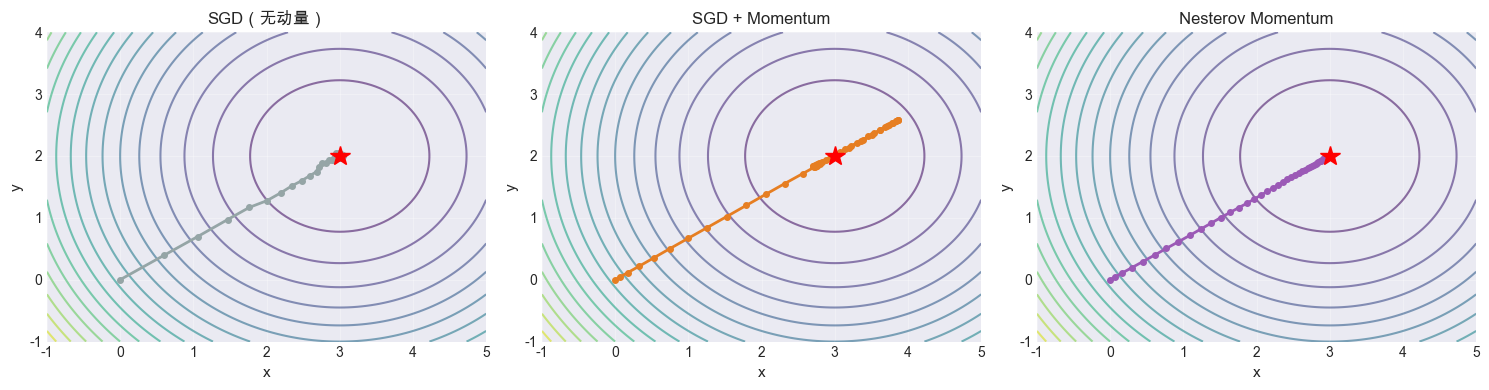


🚀 动量的优势：
1. 减少震荡，加速收敛
2. 能够越过局部平台区域
3. Nesterov变体在理论和实践中都表现更好


In [5]:
"""
Momentum梯度下降

更新规则:
    v_t = β * v_{t-1} + (1 - β) * ∇L(θ_{t-1})
    θ_t = θ_{t-1} - α * v_t

其中:
    v_t: 速度向量（梯度的指数加权平均）
    β: 动量系数（通常取0.9）
    α: 学习率
    ∇L(θ): 梯度
"""

def momentum_gd(x_init, y_init, learning_rate=0.1, beta=0.9, n_iterations=50):
    """
    带动量的梯度下降
    
    参数:
        x_init, y_init: 初始位置
        learning_rate: 学习率 α
        beta: 动量系数 β（0到1之间，通常0.9）
        n_iterations: 迭代次数
    
    返回:
        trajectory: 优化路径, shape (n_iterations+1, 2)
    """
    x, y = x_init, y_init
    trajectory = [(x, y)]
    
    # 初始化速度向量
    v_x, v_y = 0, 0
    
    for _ in range(n_iterations):
        # 1. 计算当前梯度
        grad_x, grad_y = gradient(x, y, noise_std=0.15)
        
        # 2. 更新速度向量（动量）
        v_x = beta * v_x + (1 - beta) * grad_x
        v_y = beta * v_y + (1 - beta) * grad_y
        
        # 3. 使用速度更新参数
        x -= learning_rate * v_x
        y -= learning_rate * v_y
        
        trajectory.append((x, y))
    
    return np.array(trajectory)


def nesterov_momentum_gd(x_init, y_init, learning_rate=0.1, beta=0.9, n_iterations=50):
    """
    Nesterov加速梯度下降
    
    更新规则:
        θ_lookahead = θ_{t-1} - β * v_{t-1}  (先'跳'一步)
        v_t = β * v_{t-1} + (1 - β) * ∇L(θ_lookahead)  (在跳跃点计算梯度)
        θ_t = θ_{t-1} - α * v_t
    
    优点:
    - 比标准Momentum更快收敛
    - 在凸优化中有更好的理论保证
    """
    x, y = x_init, y_init
    trajectory = [(x, y)]
    
    v_x, v_y = 0, 0
    
    for _ in range(n_iterations):
        # 1. 先"跳跃"到预估位置
        x_lookahead = x - beta * v_x
        y_lookahead = y - beta * v_y
        
        # 2. 在跳跃点计算梯度
        grad_x, grad_y = gradient(x_lookahead, y_lookahead, noise_std=0.15)
        
        # 3. 更新速度
        v_x = beta * v_x + (1 - beta) * grad_x
        v_y = beta * v_y + (1 - beta) * grad_y
        
        # 4. 更新参数
        x -= learning_rate * v_x
        y -= learning_rate * v_y
        
        trajectory.append((x, y))
    
    return np.array(trajectory)


# 对比SGD、Momentum、Nesterov
traj_sgd = minibatch_gd(0, 0, learning_rate=0.1)
traj_momentum = momentum_gd(0, 0, learning_rate=0.1, beta=0.9)
traj_nesterov = nesterov_momentum_gd(0, 0, learning_rate=0.1, beta=0.9)

plt.figure(figsize=(15, 4))

for i, (traj, title, color) in enumerate([
    (traj_sgd, 'SGD（无动量）', '#95a5a6'),
    (traj_momentum, 'SGD + Momentum', '#e67e22'),
    (traj_nesterov, 'Nesterov Momentum', '#9b59b6')
]):
    plt.subplot(1, 3, i + 1)
    plt.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
    plt.plot(traj[:, 0], traj[:, 1], 'o-', color=color, linewidth=2, markersize=4)
    plt.plot(3, 2, 'r*', markersize=15)
    plt.xlabel('x', fontsize=11)
    plt.ylabel('y', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🚀 动量的优势：")
print("1. 减少震荡，加速收敛")
print("2. 能够越过局部平台区域")
print("3. Nesterov变体在理论和实践中都表现更好")

---

## 4. 自适应学习率优化器

### 4.1 AdaGrad - 自适应梯度

In [6]:
"""
AdaGrad（Adaptive Gradient）

核心思想：
- 为每个参数设置不同的学习率
- 频繁更新的参数，学习率逐渐减小
- 稀疏更新的参数，学习率保持较大

更新规则:
    G_t = G_{t-1} + g_t^2  (累积梯度平方和)
    θ_t = θ_{t-1} - α / sqrt(G_t + ε) * g_t

其中:
    g_t: 当前梯度
    G_t: 累积的梯度平方和
    α: 初始学习率
    ε: 防止除零的小常数（通常1e-8）

优点:
- 自动调整学习率，减少手工调参
- 适合稀疏数据和稀疏梯度

缺点:
- 学习率单调递减，可能过早停止
"""

class AdaGrad:
    def __init__(self, learning_rate=0.01, epsilon=1e-8):
        """
        AdaGrad优化器
        
        参数:
            learning_rate: 初始学习率 α
            epsilon: 数值稳定性常数 ε
        """
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.G = None  # 累积梯度平方和
    
    def update(self, params, grads):
        """
        更新参数
        
        参数:
            params: list of arrays, 当前参数
            grads: list of arrays, 当前梯度
        
        返回:
            updated_params: list of arrays, 更新后的参数
        """
        # 首次调用时初始化G
        if self.G is None:
            self.G = [np.zeros_like(p) for p in params]
        
        updated_params = []
        
        for i, (p, g) in enumerate(zip(params, grads)):
            # 1. 累积梯度平方
            self.G[i] += g ** 2
            
            # 2. 自适应学习率更新
            # lr_effective = α / sqrt(G + ε)
            p_new = p - self.learning_rate * g / (np.sqrt(self.G[i]) + self.epsilon)
            
            updated_params.append(p_new)
        
        return updated_params


print("AdaGrad优化器实现完成！")
print("\n特点：为每个参数自适应调整学习率")

AdaGrad优化器实现完成！

特点：为每个参数自适应调整学习率


### 4.2 RMSprop - 改进的AdaGrad

In [9]:
"""
RMSprop（Root Mean Square Propagation）

改进思路：
- AdaGrad的G_t单调递增，导致学习率过早衰减
- RMSprop使用指数加权移动平均，只关注近期梯度

更新规则:
    E[g^2]_t = β * E[g^2]_{t-1} + (1 - β) * g_t^2  (梯度平方的指数移动平均)
    θ_t = θ_{t-1} - α / sqrt(E[g^2]_t + ε) * g_t

其中:
    β: 衰减率（通常0.9或0.99）
    E[g^2]: 梯度平方的指数加权平均

优点:
- 解决了AdaGrad学习率过早衰减的问题
- 适合非平稳目标（训练过程中分布变化）
"""

class RMSprop:
    def __init__(self, learning_rate=0.001, beta=0.9, epsilon=1e-8):
        """
        RMSprop优化器
        
        参数:
            learning_rate: 学习率 α
            beta: 梯度平方的衰减率 β
            epsilon: 数值稳定性常数 ε
        """
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.E_g2 = None  # 梯度平方的指数移动平均
    
    def update(self, params, grads):
        """
        更新参数
        
        参数:
            params: list of arrays, 当前参数
            grads: list of arrays, 当前梯度
        
        返回:
            updated_params: list of arrays, 更新后的参数
        """
        # 首次调用时初始化
        if self.E_g2 is None:
            self.E_g2 = [np.zeros_like(p) for p in params]
        
        updated_params = []
        
        for i, (p, g) in enumerate(zip(params, grads)):
            # 1. 更新梯度平方的指数移动平均
            self.E_g2[i] = self.beta * self.E_g2[i] + (1 - self.beta) * g ** 2
            
            # 2. 自适应学习率更新
            p_new = p - self.learning_rate * g / (np.sqrt(self.E_g2[i]) + self.epsilon)
            
            updated_params.append(p_new)
        
        return updated_params


print("RMSprop优化器实现完成！")
print("\n相比AdaGrad的改进：使用指数移动平均，避免学习率过早衰减")

RMSprop优化器实现完成！

相比AdaGrad的改进：使用指数移动平均，避免学习率过早衰减


### 4.3 Adam - 自适应矩估计

In [7]:
"""
Adam（Adaptive Moment Estimation）

核心思想：
- 结合Momentum（一阶矩估计）和RMSprop（二阶矩估计）
- 是目前最流行的深度学习优化器

完整算法:
    1. 计算梯度: g_t = ∇L(θ_{t-1})
    2. 更新一阶矩估计（均值）:
       m_t = β1 * m_{t-1} + (1 - β1) * g_t
    3. 更新二阶矩估计（非中心方差）:
       v_t = β2 * v_{t-1} + (1 - β2) * g_t^2
    4. 偏差修正:
       m̂_t = m_t / (1 - β1^t)
       v̂_t = v_t / (1 - β2^t)
    5. 参数更新:
       θ_t = θ_{t-1} - α * m̂_t / (sqrt(v̂_t) + ε)

超参数默认值（论文推荐）:
    α = 0.001     (学习率)
    β1 = 0.9      (一阶矩衰减率)
    β2 = 0.999    (二阶矩衰减率)
    ε = 1e-8      (数值稳定性)

偏差修正的必要性：
- m和v初始化为0，导致早期训练时估计偏向0
- 通过除以(1 - β^t)进行修正
"""

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        Adam优化器
        
        参数:
            learning_rate: 学习率 α
            beta1: 一阶矩估计的衰减率
            beta2: 二阶矩估计的衰减率
            epsilon: 数值稳定性常数
        """
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        self.m = None  # 一阶矩估计（梯度的指数移动平均）
        self.v = None  # 二阶矩估计（梯度平方的指数移动平均）
        self.t = 0     # 时间步
    
    def update(self, params, grads):
        """
        更新参数
        
        参数:
            params: list of arrays, 当前参数
            grads: list of arrays, 当前梯度
        
        返回:
            updated_params: list of arrays, 更新后的参数
        """
        # 首次调用时初始化
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]
        
        # 增加时间步
        self.t += 1
        
        updated_params = []
        
        for i, (p, g) in enumerate(zip(params, grads)):
            # 1. 更新一阶矩估计（类似Momentum）
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            
            # 2. 更新二阶矩估计（类似RMSprop）
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * g ** 2
            
            # 3. 偏差修正
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # 4. 参数更新
            p_new = p - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
            updated_params.append(p_new)
        
        return updated_params


print("Adam优化器实现完成！")
print("\n🌟 Adam的优势：")
print("1. 结合了Momentum和RMSprop的优点")
print("2. 对超参数不敏感，默认值通常工作良好")
print("3. 偏差修正确保早期训练稳定")
print("4. 是深度学习中最常用的优化器")

Adam优化器实现完成！

🌟 Adam的优势：
1. 结合了Momentum和RMSprop的优点
2. 对超参数不敏感，默认值通常工作良好
3. 偏差修正确保早期训练稳定
4. 是深度学习中最常用的优化器


### 4.4 优化器对比

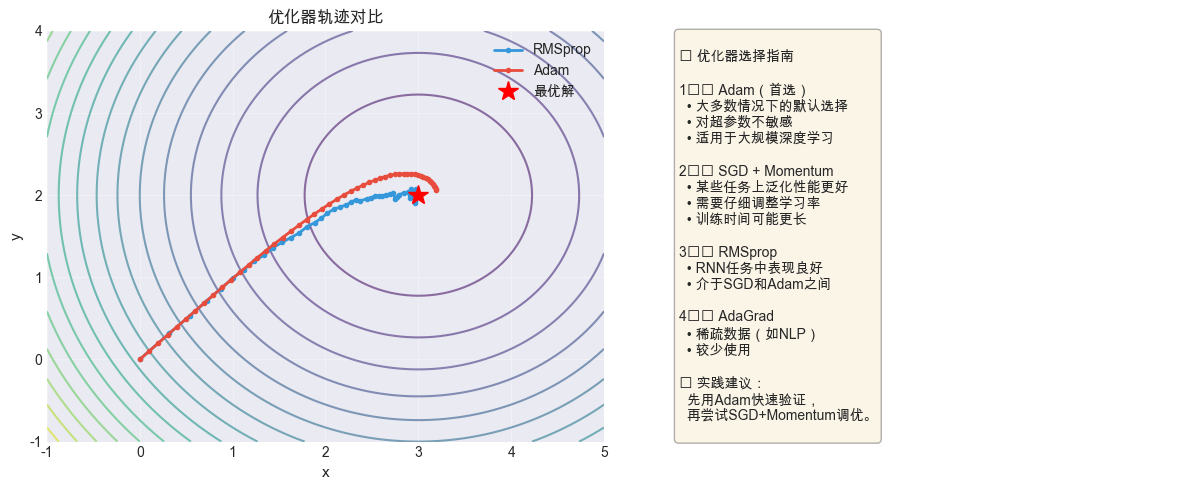

In [10]:
# 在简单优化问题上对比不同优化器
def test_optimizer(optimizer_class, **kwargs):
    """测试优化器性能"""
    # 初始化参数（模拟一个2D参数空间）
    x, y = 0.0, 0.0
    trajectory = [(x, y)]
    
    # 创建优化器
    optimizer = optimizer_class(**kwargs)
    
    for _ in range(50):
        # 计算梯度
        grad_x, grad_y = gradient(x, y, noise_std=0.2)
        
        # 使用优化器更新参数
        params = [np.array([x]), np.array([y])]
        grads = [np.array([grad_x]), np.array([grad_y])]
        updated_params = optimizer.update(params, grads)
        
        x = updated_params[0][0]
        y = updated_params[1][0]
        trajectory.append((x, y))
    
    return np.array(trajectory)


# 测试不同优化器
optimizers = [
    (RMSprop, {'learning_rate': 0.1}, 'RMSprop', '#3498db'),
    (Adam, {'learning_rate': 0.1}, 'Adam', '#e74c3c'),
]

plt.figure(figsize=(12, 5))

# 绘制轨迹对比
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)

for opt_class, kwargs, name, color in optimizers:
    traj = test_optimizer(opt_class, **kwargs)
    plt.plot(traj[:, 0], traj[:, 1], 'o-', label=name, color=color, linewidth=2, markersize=3)

plt.plot(3, 2, 'r*', markersize=15, label='最优解')
plt.xlabel('x', fontsize=11)
plt.ylabel('y', fontsize=11)
plt.title('优化器轨迹对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 优化器选择指南
plt.subplot(1, 2, 2)
guide_text = """
📋 优化器选择指南

1️⃣ Adam（首选）
  • 大多数情况下的默认选择
  • 对超参数不敏感
  • 适用于大规模深度学习

2️⃣ SGD + Momentum
  • 某些任务上泛化性能更好
  • 需要仔细调整学习率
  • 训练时间可能更长

3️⃣ RMSprop
  • RNN任务中表现良好
  • 介于SGD和Adam之间

4️⃣ AdaGrad
  • 稀疏数据（如NLP）
  • 较少使用

💡 实践建议：
  先用Adam快速验证，
  再尝试SGD+Momentum调优。
"""
plt.text(0.1, 0.5, guide_text, fontsize=10, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.show()

---

## 5. 学习率调度（Learning Rate Scheduling）

### 为什么需要学习率衰减？

- 训练初期：需要大学习率快速接近最优解
- 训练后期：需要小学习率精细调整，避免震荡

### 5.1 常见学习率调度策略

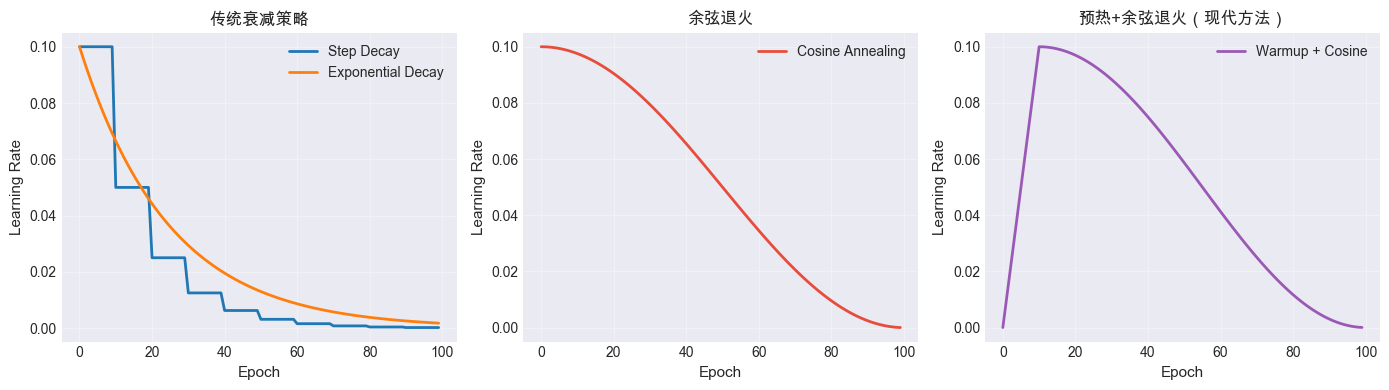


📈 学习率调度选择建议：
1. Step Decay: 简单任务，容易调参
2. Cosine Annealing: 现代深度学习的流行选择
3. Warmup + Cosine: Transformer等大模型的标准配置


In [11]:
def step_decay(initial_lr, epoch, drop_rate=0.5, epochs_drop=10):
    """
    阶梯衰减（Step Decay）
    
    公式: lr = initial_lr * drop_rate^(floor(epoch / epochs_drop))
    
    参数:
        initial_lr: 初始学习率
        epoch: 当前轮数
        drop_rate: 衰减因子（如0.5表示每次减半）
        epochs_drop: 每隔多少轮衰减一次
    
    示例:
        初始lr=0.1, drop_rate=0.5, epochs_drop=10
        epoch 0-9: lr=0.1
        epoch 10-19: lr=0.05
        epoch 20-29: lr=0.025
    """
    return initial_lr * (drop_rate ** (epoch // epochs_drop))


def exponential_decay(initial_lr, epoch, decay_rate=0.95):
    """
    指数衰减（Exponential Decay）
    
    公式: lr = initial_lr * decay_rate^epoch
    
    参数:
        initial_lr: 初始学习率
        epoch: 当前轮数
        decay_rate: 衰减率（通常0.9-0.99）
    
    特点:
        平滑、连续的衰减
    """
    return initial_lr * (decay_rate ** epoch)


def cosine_annealing(initial_lr, epoch, T_max):
    """
    余弦退火（Cosine Annealing）
    
    公式: lr = lr_min + 0.5 * (initial_lr - lr_min) * (1 + cos(π * epoch / T_max))
    
    参数:
        initial_lr: 初始学习率
        epoch: 当前轮数
        T_max: 总训练轮数
    
    特点:
        - 开始时快速衰减
        - 后期缓慢衰减
        - 曲线平滑
    """
    lr_min = 0
    return lr_min + 0.5 * (initial_lr - lr_min) * (1 + np.cos(np.pi * epoch / T_max))


def warmup_cosine(initial_lr, epoch, T_max, warmup_epochs=5):
    """
    带预热的余弦退火（Warmup + Cosine Annealing）
    
    预热阶段（0到warmup_epochs）:
        lr = initial_lr * (epoch / warmup_epochs)
    
    退火阶段（warmup_epochs到T_max）:
        应用余弦退火
    
    特点:
        - 初期缓慢增加学习率（稳定训练）
        - 后期余弦衰减
        - 常用于Transformer等大模型
    """
    if epoch < warmup_epochs:
        # 预热阶段：线性增长
        return initial_lr * (epoch / warmup_epochs)
    else:
        # 退火阶段
        effective_epoch = epoch - warmup_epochs
        effective_T_max = T_max - warmup_epochs
        return cosine_annealing(initial_lr, effective_epoch, effective_T_max)


# 可视化不同学习率调度策略
initial_lr = 0.1
epochs = np.arange(0, 100)

lr_step = [step_decay(initial_lr, e) for e in epochs]
lr_exp = [exponential_decay(initial_lr, e, decay_rate=0.96) for e in epochs]
lr_cos = [cosine_annealing(initial_lr, e, T_max=100) for e in epochs]
lr_warmup = [warmup_cosine(initial_lr, e, T_max=100, warmup_epochs=10) for e in epochs]

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, lr_step, label='Step Decay', linewidth=2)
plt.plot(epochs, lr_exp, label='Exponential Decay', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Learning Rate', fontsize=11)
plt.title('传统衰减策略', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(epochs, lr_cos, label='Cosine Annealing', linewidth=2, color='#e74c3c')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Learning Rate', fontsize=11)
plt.title('余弦退火', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(epochs, lr_warmup, label='Warmup + Cosine', linewidth=2, color='#9b59b6')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Learning Rate', fontsize=11)
plt.title('预热+余弦退火（现代方法）', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 学习率调度选择建议：")
print("1. Step Decay: 简单任务，容易调参")
print("2. Cosine Annealing: 现代深度学习的流行选择")
print("3. Warmup + Cosine: Transformer等大模型的标准配置")

---

## 6. 综合实战：MNIST手写数字分类

### 项目目标
在MNIST数据集上训练一个两层神经网络，对比不同优化器和学习率策略的效果。

### 6.1 数据准备

数据集大小: (1797, 64)
标签范围: 0 - 9

训练集: (1437, 64), 测试集: (360, 64)


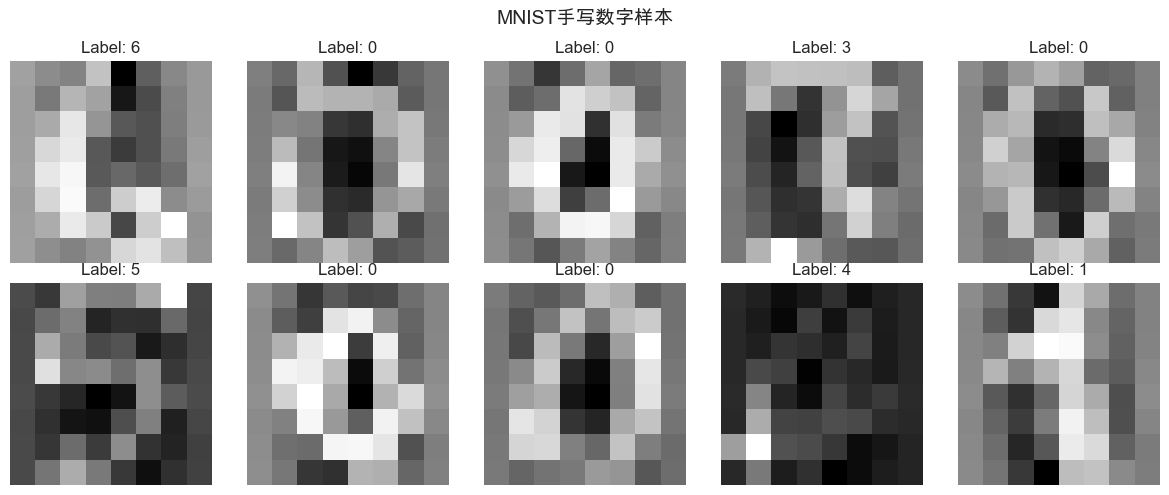

In [12]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 加载手写数字数据集（sklearn自带的8x8简化版MNIST）
digits = load_digits()
X = digits.data  # shape: (1797, 64)，每张图片8x8=64像素
y = digits.target  # shape: (1797,)，标签0-9

print(f"数据集大小: {X.shape}")
print(f"标签范围: {np.min(y)} - {np.max(y)}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 转换标签为one-hot编码
def to_one_hot(y, n_classes=10):
    """将标签转换为one-hot编码"""
    one_hot = np.zeros((len(y), n_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

y_train_onehot = to_one_hot(y_train)
y_test_onehot = to_one_hot(y_test)

print(f"\n训练集: {X_train.shape}, 测试集: {X_test.shape}")

# 可视化部分样本
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.suptitle('MNIST手写数字样本', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.2 构建神经网络（复用前面章节的代码）

In [13]:
# 激活函数
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    if z.ndim == 1:
        z_shifted = z - np.max(z)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z)
    else:
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)


class NeuralNetwork:
    """
    两层神经网络
    结构: 输入层(64) → 隐藏层(128) → 输出层(10)
    """
    def __init__(self, input_size=64, hidden_size=128, output_size=10):
        # He初始化
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros(output_size)
    
    def forward(self, X):
        """前向传播"""
        # 隐藏层
        self.z1 = X @ self.W1.T + self.b1  # (m, 128)
        self.a1 = relu(self.z1)            # (m, 128)
        
        # 输出层
        self.z2 = self.a1 @ self.W2.T + self.b2  # (m, 10)
        self.a2 = softmax(self.z2)               # (m, 10)
        
        return self.a2
    
    def backward(self, X, y_true):
        """反向传播，返回梯度"""
        m = X.shape[0]
        
        # 输出层梯度
        delta2 = self.a2 - y_true  # (m, 10)
        grad_W2 = delta2.T @ self.a1 / m  # (10, 128)
        grad_b2 = np.mean(delta2, axis=0)  # (10,)
        
        # 隐藏层梯度
        delta1 = (delta2 @ self.W2) * relu_derivative(self.z1)  # (m, 128)
        grad_W1 = delta1.T @ X / m  # (128, 64)
        grad_b1 = np.mean(delta1, axis=0)  # (128,)
        
        return [grad_W1, grad_b1, grad_W2, grad_b2]
    
    def get_params(self):
        """获取所有参数"""
        return [self.W1, self.b1, self.W2, self.b2]
    
    def set_params(self, params):
        """设置所有参数"""
        self.W1, self.b1, self.W2, self.b2 = params
    
    def compute_loss(self, X, y_true):
        """计算交叉熵损失"""
        y_pred = self.forward(X)
        return categorical_cross_entropy(y_true, y_pred)
    
    def compute_accuracy(self, X, y_true):
        """计算准确率"""
        y_pred = self.forward(X)
        predictions = np.argmax(y_pred, axis=1)
        labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == labels)


print("神经网络类定义完成！")

神经网络类定义完成！


### 6.3 对比不同优化器的训练效果


=== 训练 RMSprop ===
Epoch 10/50, Loss: 0.0209, Train Acc: 0.9993, Test Acc: 0.9667
Epoch 20/50, Loss: 0.0013, Train Acc: 1.0000, Test Acc: 0.9750
Epoch 30/50, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.9750
Epoch 40/50, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.9750
Epoch 50/50, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.9750

=== 训练 Adam ===
Epoch 10/50, Loss: 0.0641, Train Acc: 0.9958, Test Acc: 0.9611
Epoch 20/50, Loss: 0.0198, Train Acc: 0.9993, Test Acc: 0.9667
Epoch 30/50, Loss: 0.0090, Train Acc: 1.0000, Test Acc: 0.9694
Epoch 40/50, Loss: 0.0049, Train Acc: 1.0000, Test Acc: 0.9694
Epoch 50/50, Loss: 0.0030, Train Acc: 1.0000, Test Acc: 0.9694


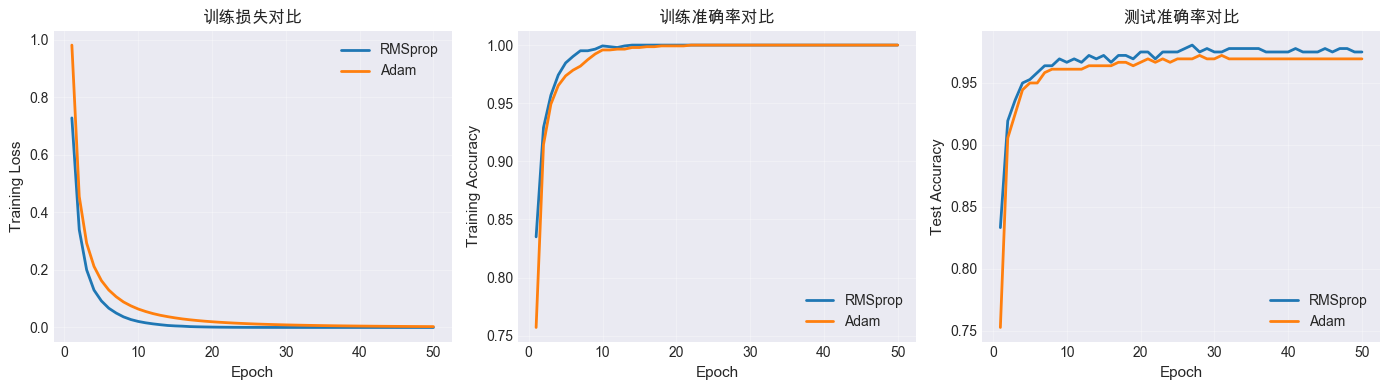


🎯 最终结果：
RMSprop - 训练准确率: 1.0000, 测试准确率: 0.9750
Adam    - 训练准确率: 1.0000, 测试准确率: 0.9694


In [14]:
def train_with_optimizer(optimizer_class, optimizer_kwargs, n_epochs=50, batch_size=32):
    """
    使用指定优化器训练网络
    
    参数:
        optimizer_class: 优化器类
        optimizer_kwargs: 优化器参数
        n_epochs: 训练轮数
        batch_size: 批量大小
    
    返回:
        train_losses, train_accs, test_accs: 训练历史
    """
    # 初始化模型和优化器
    model = NeuralNetwork()
    optimizer = optimizer_class(**optimizer_kwargs)
    
    train_losses = []
    train_accs = []
    test_accs = []
    
    n_batches = int(np.ceil(len(X_train) / batch_size))
    
    for epoch in range(n_epochs):
        # 打乱数据
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train_onehot[indices]
        
        # Mini-batch训练
        for batch in range(n_batches):
            start = batch * batch_size
            end = min(start + batch_size, len(X_train))
            
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            
            # 前向传播
            model.forward(X_batch)
            
            # 反向传播
            grads = model.backward(X_batch, y_batch)
            
            # 优化器更新参数
            params = model.get_params()
            updated_params = optimizer.update(params, grads)
            model.set_params(updated_params)
        
        # 记录训练指标
        train_loss = model.compute_loss(X_train, y_train_onehot)
        train_acc = model.compute_accuracy(X_train, y_train_onehot)
        test_acc = model.compute_accuracy(X_test, y_test_onehot)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
    return train_losses, train_accs, test_accs


# 训练对比
print("\n=== 训练 RMSprop ===")
rmsprop_losses, rmsprop_train_accs, rmsprop_test_accs = train_with_optimizer(
    RMSprop, {'learning_rate': 0.001}, n_epochs=50
)

print("\n=== 训练 Adam ===")
adam_losses, adam_train_accs, adam_test_accs = train_with_optimizer(
    Adam, {'learning_rate': 0.001}, n_epochs=50
)


# 可视化对比
epochs = np.arange(1, 51)

plt.figure(figsize=(14, 4))

# 损失曲线
plt.subplot(1, 3, 1)
plt.plot(epochs, rmsprop_losses, label='RMSprop', linewidth=2)
plt.plot(epochs, adam_losses, label='Adam', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Training Loss', fontsize=11)
plt.title('训练损失对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 训练准确率
plt.subplot(1, 3, 2)
plt.plot(epochs, rmsprop_train_accs, label='RMSprop', linewidth=2)
plt.plot(epochs, adam_train_accs, label='Adam', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Training Accuracy', fontsize=11)
plt.title('训练准确率对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 测试准确率
plt.subplot(1, 3, 3)
plt.plot(epochs, rmsprop_test_accs, label='RMSprop', linewidth=2)
plt.plot(epochs, adam_test_accs, label='Adam', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Test Accuracy', fontsize=11)
plt.title('测试准确率对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 最终结果：")
print(f"RMSprop - 训练准确率: {rmsprop_train_accs[-1]:.4f}, 测试准确率: {rmsprop_test_accs[-1]:.4f}")
print(f"Adam    - 训练准确率: {adam_train_accs[-1]:.4f}, 测试准确率: {adam_test_accs[-1]:.4f}")

---

## 7. 本章总结

### 核心知识回顾

#### 1. 损失函数
- **回归任务**：MSE（默认）、MAE（鲁棒）、Huber（综合）
- **分类任务**：交叉熵（神经网络标准）、Hinge Loss（SVM）

#### 2. 梯度下降变体
- **BGD**：稳定但慢
- **SGD**：快但震荡
- **Mini-batch GD**：实践标准

#### 3. 优化器
- **Momentum**：加速收敛，减少震荡
- **RMSprop**：自适应学习率
- **Adam**：结合Momentum和RMSprop，最流行

#### 4. 学习率调度
- **Step Decay**：简单有效
- **Cosine Annealing**：现代推荐
- **Warmup + Cosine**：大模型标准

---

### 实践建议

```python
# 快速开始配置（适用于大多数情况）
optimizer = Adam(learning_rate=0.001)
batch_size = 32
epochs = 100
```

```python
# 追求最佳泛化性能配置
optimizer = SGD_with_Momentum(learning_rate=0.01, momentum=0.9)
lr_scheduler = CosineAnnealing(T_max=epochs)
```

---

### 常见问题

**Q: Adam vs SGD+Momentum，哪个更好？**

A: 
- Adam：收敛快，容易调参，适合快速验证
- SGD+Momentum：某些任务上泛化更好，但需要仔细调整学习率
- 建议：先用Adam验证，再尝试SGD+Momentum优化

**Q: 学习率应该设多大？**

A:
- Adam默认0.001通常有效
- SGD可以尝试0.01-0.1
- 使用学习率调度可以降低对初始值的敏感度

**Q: Batch size如何选择？**

A:
- 常用：32、64、128、256
- 更大的batch size：训练稳定，但可能泛化差
- 更小的batch size：泛化好，但训练不稳定
- GPU内存限制也会影响选择

---

## 8. 练习题

### 练习1：实现AdamW优化器
AdamW是Adam的改进版本，将权重衰减（L2正则化）与梯度更新解耦。

```python
# 提示：AdamW的更新规则
# θ_t = θ_{t-1} - α * (m̂_t / (sqrt(v̂_t) + ε) + λ * θ_{t-1})
# 其中λ是权重衰减系数
```

### 练习2：实验不同的学习率调度策略
在MNIST数据集上，对比以下学习率调度的效果：
1. 固定学习率
2. Step Decay
3. Cosine Annealing
4. Warmup + Cosine

### 练习3：分析Batch Size的影响
使用相同的优化器（如Adam），对比batch_size=[16, 32, 64, 128]的训练效果。

观察：
- 收敛速度
- 最终测试准确率
- 训练稳定性

### 练习4：实现学习率查找器
实现一个工具，自动搜索最佳学习率：
1. 从很小的学习率开始（如1e-7）
2. 每个batch指数增长学习率
3. 记录损失变化
4. 找到损失下降最快的学习率区间

---

### 练习2 答案：实验不同的学习率调度策略

In [15]:
"""
练习2：实验不同的学习率调度策略

目标：在MNIST数据集上，对比以下学习率调度的效果：
1. 固定学习率 (Constant)
2. 阶梯衰减 (Step Decay)
3. 余弦退火 (Cosine Annealing)
4. 预热+余弦退火 (Warmup + Cosine)

我们将使用SGD优化器（不带动量），以便更清楚地观察学习率调度的影响。
"""

# ============================================================
# 第一步：实现带学习率调度的SGD优化器
# ============================================================

class SGD:
    """
    基础SGD优化器
    
    更新规则:
        θ_t = θ_{t-1} - α * g_t
    
    参数:
        learning_rate: 学习率 α
    """
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
    
    def update(self, params, grads):
        """
        更新参数
        
        参数:
            params: list of arrays, 当前参数
            grads: list of arrays, 当前梯度
        
        返回:
            updated_params: list of arrays, 更新后的参数
        """
        updated_params = []
        for p, g in zip(params, grads):
            # 简单的梯度下降更新
            p_new = p - self.learning_rate * g
            updated_params.append(p_new)
        return updated_params
    
    def set_learning_rate(self, lr):
        """动态设置学习率（用于学习率调度）"""
        self.learning_rate = lr


print("SGD优化器定义完成！")

SGD优化器定义完成！


In [16]:
# ============================================================
# 第二步：实现学习率调度器类
# ============================================================

class LRScheduler:
    """
    学习率调度器基类
    
    所有调度器都继承此类，实现 get_lr(epoch) 方法
    """
    def __init__(self, initial_lr):
        self.initial_lr = initial_lr
    
    def get_lr(self, epoch):
        """返回当前epoch的学习率"""
        raise NotImplementedError


class ConstantLR(LRScheduler):
    """
    固定学习率（不衰减）
    
    公式: lr = initial_lr（恒定不变）
    
    特点:
    - 最简单的策略
    - 不需要调参
    - 可能在训练后期震荡
    """
    def get_lr(self, epoch):
        # 始终返回初始学习率
        return self.initial_lr


class StepDecayLR(LRScheduler):
    """
    阶梯衰减学习率
    
    公式: lr = initial_lr * drop_rate^(epoch // epochs_drop)
    
    参数:
        initial_lr: 初始学习率
        drop_rate: 每次衰减的比例（如0.5表示减半）
        epochs_drop: 每隔多少轮衰减一次
    
    特点:
    - 简单直观
    - 需要手动设置衰减时机
    - 学习率变化不平滑
    """
    def __init__(self, initial_lr, drop_rate=0.5, epochs_drop=20):
        super().__init__(initial_lr)
        self.drop_rate = drop_rate      # 衰减比例
        self.epochs_drop = epochs_drop  # 衰减间隔
    
    def get_lr(self, epoch):
        # 计算衰减次数
        n_drops = epoch // self.epochs_drop
        # 应用衰减
        return self.initial_lr * (self.drop_rate ** n_drops)


class CosineAnnealingLR(LRScheduler):
    """
    余弦退火学习率
    
    公式: lr = lr_min + 0.5 * (initial_lr - lr_min) * (1 + cos(π * epoch / T_max))
    
    参数:
        initial_lr: 初始学习率
        T_max: 总训练轮数
        lr_min: 最小学习率（默认0）
    
    特点:
    - 平滑的学习率衰减曲线
    - 开始时衰减快，后期衰减慢
    - 现代深度学习常用策略
    """
    def __init__(self, initial_lr, T_max, lr_min=0):
        super().__init__(initial_lr)
        self.T_max = T_max    # 总轮数
        self.lr_min = lr_min  # 最小学习率
    
    def get_lr(self, epoch):
        # 余弦退火公式
        # cos值从1（epoch=0）逐渐变为-1（epoch=T_max）
        # 学习率从initial_lr逐渐变为lr_min
        cos_value = np.cos(np.pi * epoch / self.T_max)
        lr = self.lr_min + 0.5 * (self.initial_lr - self.lr_min) * (1 + cos_value)
        return lr


class WarmupCosineLR(LRScheduler):
    """
    预热+余弦退火学习率
    
    预热阶段（0 到 warmup_epochs）:
        lr = initial_lr * (epoch / warmup_epochs)  # 线性增长
    
    退火阶段（warmup_epochs 到 T_max）:
        lr = 余弦退火公式
    
    参数:
        initial_lr: 目标学习率（预热结束后达到）
        T_max: 总训练轮数
        warmup_epochs: 预热轮数
        lr_min: 最小学习率
    
    特点:
    - 训练初期学习率较小，稳定训练
    - 预热后达到目标学习率
    - 之后余弦衰减
    - Transformer等大模型的标准配置
    """
    def __init__(self, initial_lr, T_max, warmup_epochs=5, lr_min=0):
        super().__init__(initial_lr)
        self.T_max = T_max
        self.warmup_epochs = warmup_epochs
        self.lr_min = lr_min
    
    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            # 预热阶段：学习率从0线性增长到initial_lr
            # 避免除零，当epoch=0时返回很小的学习率
            return self.initial_lr * (epoch + 1) / self.warmup_epochs
        else:
            # 退火阶段：余弦衰减
            # 调整epoch，使余弦从预热结束后开始
            effective_epoch = epoch - self.warmup_epochs
            effective_T_max = self.T_max - self.warmup_epochs
            
            cos_value = np.cos(np.pi * effective_epoch / effective_T_max)
            lr = self.lr_min + 0.5 * (self.initial_lr - self.lr_min) * (1 + cos_value)
            return lr


print("四种学习率调度器定义完成！")
print("1. ConstantLR - 固定学习率")
print("2. StepDecayLR - 阶梯衰减")
print("3. CosineAnnealingLR - 余弦退火")
print("4. WarmupCosineLR - 预热+余弦退火")

四种学习率调度器定义完成！
1. ConstantLR - 固定学习率
2. StepDecayLR - 阶梯衰减
3. CosineAnnealingLR - 余弦退火
4. WarmupCosineLR - 预热+余弦退火


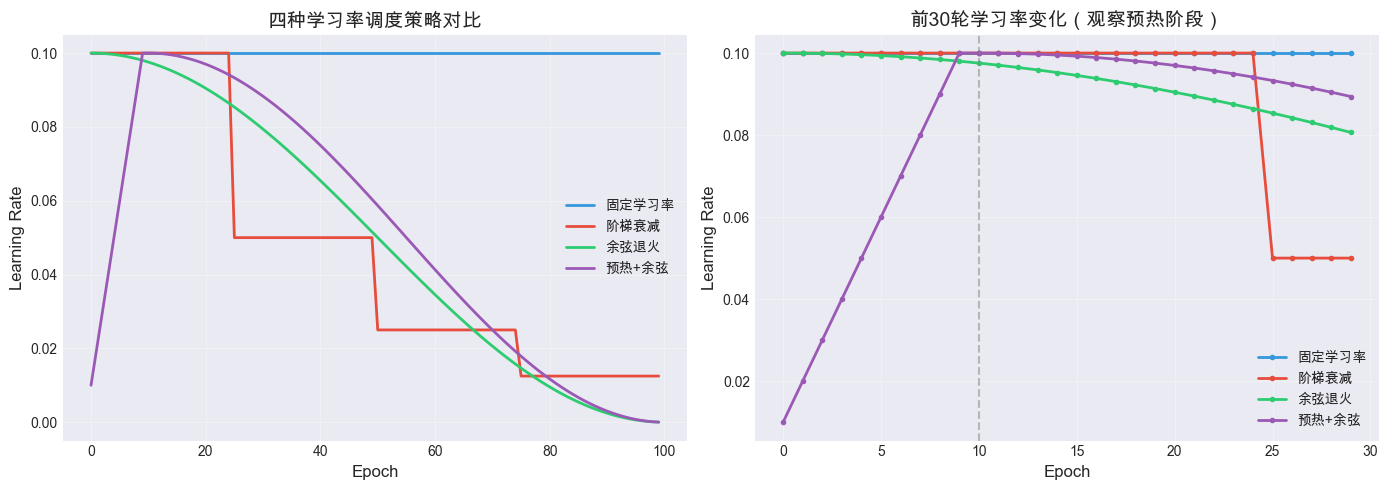


📊 关键节点学习率对比：
------------------------------------------------------------
策略              Epoch 0      Epoch 25     Epoch 50     Epoch 99    
------------------------------------------------------------
固定学习率           0.100000     0.100000     0.100000     0.100000    
阶梯衰减            0.100000     0.050000     0.025000     0.012500    
余弦退火            0.100000     0.085355     0.050000     0.000025    
预热+余弦           0.010000     0.093301     0.058682     0.000030    


In [17]:
# ============================================================
# 第三步：可视化四种学习率调度策略
# ============================================================

# 配置参数
initial_lr = 0.1  # 初始学习率
n_epochs = 100    # 总训练轮数

# 创建四种调度器
schedulers = {
    '固定学习率': ConstantLR(initial_lr),
    '阶梯衰减': StepDecayLR(initial_lr, drop_rate=0.5, epochs_drop=25),
    '余弦退火': CosineAnnealingLR(initial_lr, T_max=n_epochs),
    '预热+余弦': WarmupCosineLR(initial_lr, T_max=n_epochs, warmup_epochs=10)
}

# 计算每个epoch的学习率
epochs = np.arange(n_epochs)
lr_histories = {}

for name, scheduler in schedulers.items():
    lr_histories[name] = [scheduler.get_lr(e) for e in epochs]

# 可视化
plt.figure(figsize=(14, 5))

# 子图1：所有策略对比
plt.subplot(1, 2, 1)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
for (name, lrs), color in zip(lr_histories.items(), colors):
    plt.plot(epochs, lrs, label=name, linewidth=2, color=color)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('四种学习率调度策略对比', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 子图2：详细分析
plt.subplot(1, 2, 2)
# 放大显示前30个epoch，观察预热阶段
for (name, lrs), color in zip(lr_histories.items(), colors):
    plt.plot(epochs[:30], lrs[:30], label=name, linewidth=2, color=color, marker='o', markersize=3)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('前30轮学习率变化（观察预热阶段）', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=10, color='gray', linestyle='--', alpha=0.5, label='预热结束')

plt.tight_layout()
plt.show()

# 打印关键节点的学习率
print("\n📊 关键节点学习率对比：")
print("-" * 60)
print(f"{'策略':<15} {'Epoch 0':<12} {'Epoch 25':<12} {'Epoch 50':<12} {'Epoch 99':<12}")
print("-" * 60)
for name, lrs in lr_histories.items():
    print(f"{name:<15} {lrs[0]:<12.6f} {lrs[25]:<12.6f} {lrs[50]:<12.6f} {lrs[99]:<12.6f}")

In [18]:
# ============================================================
# 第四步：实现带学习率调度的训练函数
# ============================================================

def train_with_lr_scheduler(scheduler, n_epochs=100, batch_size=32, verbose=True):
    """
    使用学习率调度器训练神经网络
    
    参数:
        scheduler: 学习率调度器实例
        n_epochs: 训练轮数
        batch_size: 批量大小
        verbose: 是否打印训练信息
    
    返回:
        history: dict, 包含训练历史
            - train_losses: 训练损失
            - train_accs: 训练准确率
            - test_accs: 测试准确率
            - learning_rates: 每轮的学习率
    """
    # 固定随机种子，确保公平比较
    np.random.seed(42)
    
    # 初始化模型和优化器
    model = NeuralNetwork()
    optimizer = SGD(learning_rate=scheduler.get_lr(0))
    
    # 记录训练历史
    history = {
        'train_losses': [],
        'train_accs': [],
        'test_accs': [],
        'learning_rates': []
    }
    
    n_batches = int(np.ceil(len(X_train) / batch_size))
    
    for epoch in range(n_epochs):
        # ===== 1. 更新学习率 =====
        current_lr = scheduler.get_lr(epoch)
        optimizer.set_learning_rate(current_lr)
        history['learning_rates'].append(current_lr)
        
        # ===== 2. 打乱数据 =====
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train_onehot[indices]
        
        # ===== 3. Mini-batch 训练 =====
        for batch in range(n_batches):
            start = batch * batch_size
            end = min(start + batch_size, len(X_train))
            
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            
            # 前向传播
            model.forward(X_batch)
            
            # 反向传播
            grads = model.backward(X_batch, y_batch)
            
            # 参数更新
            params = model.get_params()
            updated_params = optimizer.update(params, grads)
            model.set_params(updated_params)
        
        # ===== 4. 记录训练指标 =====
        train_loss = model.compute_loss(X_train, y_train_onehot)
        train_acc = model.compute_accuracy(X_train, y_train_onehot)
        test_acc = model.compute_accuracy(X_test, y_test_onehot)
        
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)
        history['test_accs'].append(test_acc)
        
        # ===== 5. 打印进度 =====
        if verbose and (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}/{n_epochs} | "
                  f"LR: {current_lr:.6f} | "
                  f"Loss: {train_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Test Acc: {test_acc:.4f}")
    
    return history


print("训练函数定义完成！")

训练函数定义完成！


In [19]:
# ============================================================
# 第五步：训练并对比四种学习率调度策略
# ============================================================

# 配置参数
initial_lr = 0.1  # 初始学习率（SGD通常需要较大的学习率）
n_epochs = 100    # 训练轮数
batch_size = 32   # 批量大小

# 创建四种调度器
schedulers_to_test = {
    '固定学习率': ConstantLR(initial_lr),
    '阶梯衰减': StepDecayLR(initial_lr, drop_rate=0.5, epochs_drop=25),
    '余弦退火': CosineAnnealingLR(initial_lr, T_max=n_epochs),
    '预热+余弦': WarmupCosineLR(initial_lr, T_max=n_epochs, warmup_epochs=10)
}

# 存储所有训练结果
all_histories = {}

# 依次训练
for name, scheduler in schedulers_to_test.items():
    print(f"\n{'='*60}")
    print(f"训练策略: {name}")
    print('='*60)
    
    history = train_with_lr_scheduler(scheduler, n_epochs=n_epochs, batch_size=batch_size)
    all_histories[name] = history
    
    # 打印最终结果
    print(f"\n✅ {name} 最终结果:")
    print(f"   训练准确率: {history['train_accs'][-1]:.4f}")
    print(f"   测试准确率: {history['test_accs'][-1]:.4f}")

print("\n" + "="*60)
print("所有训练完成！")
print("="*60)


训练策略: 固定学习率
Epoch  20/100 | LR: 0.100000 | Loss: 0.0159 | Train Acc: 0.9993 | Test Acc: 0.9806
Epoch  40/100 | LR: 0.100000 | Loss: 0.0066 | Train Acc: 1.0000 | Test Acc: 0.9806
Epoch  60/100 | LR: 0.100000 | Loss: 0.0040 | Train Acc: 1.0000 | Test Acc: 0.9806
Epoch  80/100 | LR: 0.100000 | Loss: 0.0028 | Train Acc: 1.0000 | Test Acc: 0.9806
Epoch 100/100 | LR: 0.100000 | Loss: 0.0022 | Train Acc: 1.0000 | Test Acc: 0.9806

✅ 固定学习率 最终结果:
   训练准确率: 1.0000
   测试准确率: 0.9806

训练策略: 阶梯衰减
Epoch  20/100 | LR: 0.100000 | Loss: 0.0159 | Train Acc: 0.9993 | Test Acc: 0.9806
Epoch  40/100 | LR: 0.050000 | Loss: 0.0087 | Train Acc: 1.0000 | Test Acc: 0.9806
Epoch  60/100 | LR: 0.025000 | Loss: 0.0067 | Train Acc: 1.0000 | Test Acc: 0.9806
Epoch  80/100 | LR: 0.012500 | Loss: 0.0059 | Train Acc: 1.0000 | Test Acc: 0.9806
Epoch 100/100 | LR: 0.012500 | Loss: 0.0055 | Train Acc: 1.0000 | Test Acc: 0.9806

✅ 阶梯衰减 最终结果:
   训练准确率: 1.0000
   测试准确率: 0.9806

训练策略: 余弦退火
Epoch  20/100 | LR: 0.091354 | Loss:

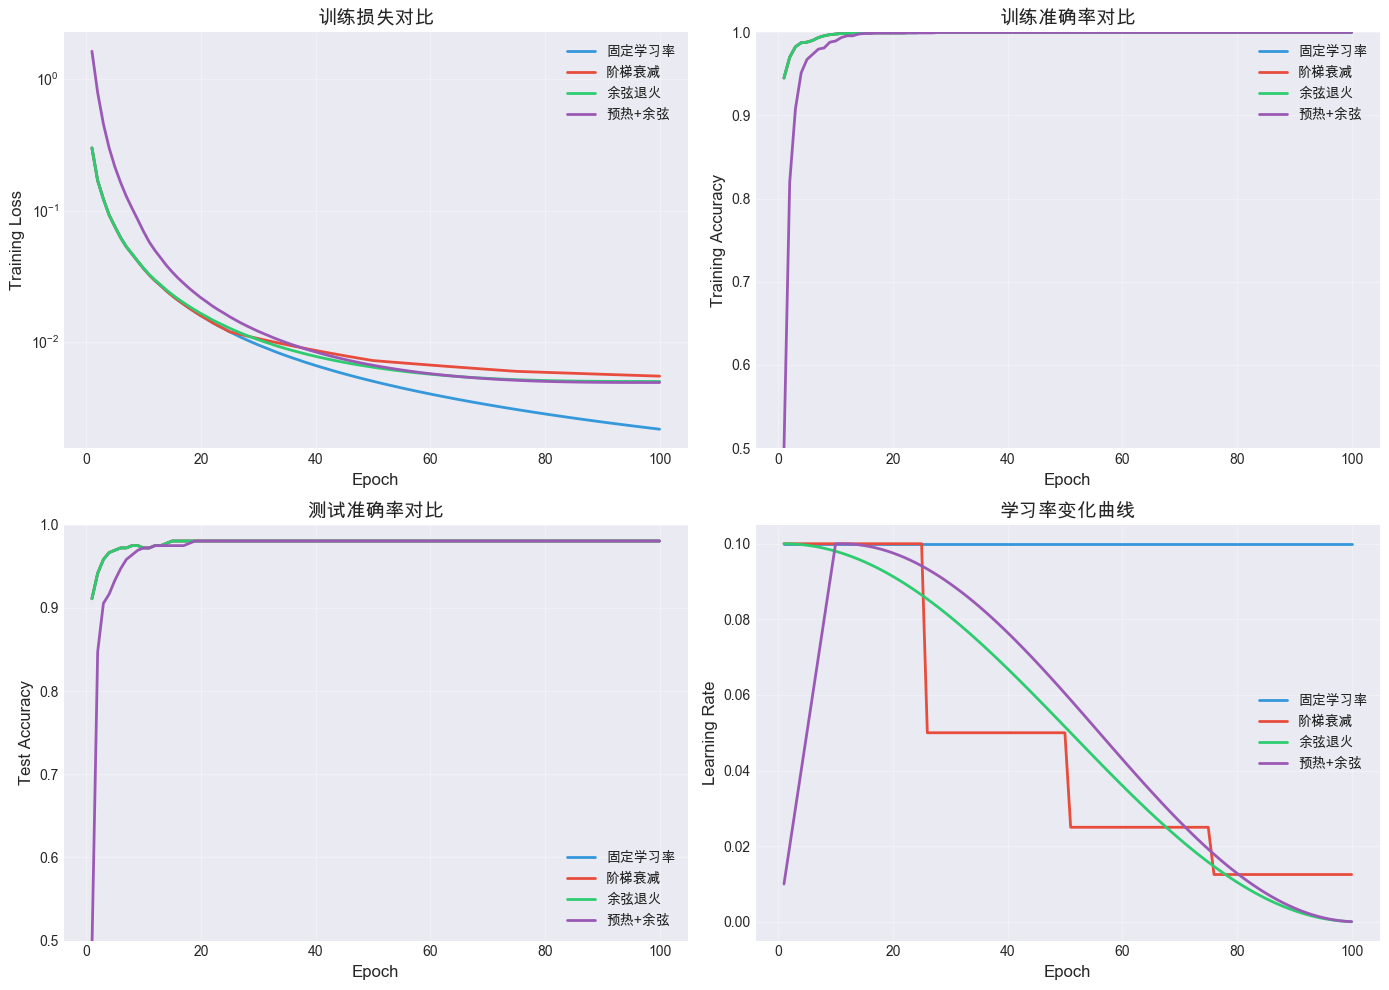

In [20]:
# ============================================================
# 第六步：可视化训练结果对比
# ============================================================

# 创建图形
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
epochs = np.arange(1, n_epochs + 1)

# ===== 子图1: 训练损失曲线 =====
ax1 = axes[0, 0]
for (name, history), color in zip(all_histories.items(), colors):
    ax1.plot(epochs, history['train_losses'], label=name, linewidth=2, color=color)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('训练损失对比', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # 使用对数刻度更清晰

# ===== 子图2: 训练准确率曲线 =====
ax2 = axes[0, 1]
for (name, history), color in zip(all_histories.items(), colors):
    ax2.plot(epochs, history['train_accs'], label=name, linewidth=2, color=color)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Training Accuracy', fontsize=12)
ax2.set_title('训练准确率对比', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.5, 1.0])

# ===== 子图3: 测试准确率曲线 =====
ax3 = axes[1, 0]
for (name, history), color in zip(all_histories.items(), colors):
    ax3.plot(epochs, history['test_accs'], label=name, linewidth=2, color=color)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Test Accuracy', fontsize=12)
ax3.set_title('测试准确率对比', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0.5, 1.0])

# ===== 子图4: 学习率变化曲线 =====
ax4 = axes[1, 1]
for (name, history), color in zip(all_histories.items(), colors):
    ax4.plot(epochs, history['learning_rates'], label=name, linewidth=2, color=color)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Learning Rate', fontsize=12)
ax4.set_title('学习率变化曲线', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# ============================================================
# 第七步：结果汇总与分析
# ============================================================

print("=" * 70)
print("📊 学习率调度策略实验结果汇总")
print("=" * 70)

# 创建结果表格
print(f"\n{'策略':<15} {'最终训练准确率':<18} {'最终测试准确率':<18} {'最佳测试准确率':<18}")
print("-" * 70)

best_strategy = None
best_test_acc = 0

for name, history in all_histories.items():
    final_train_acc = history['train_accs'][-1]
    final_test_acc = history['test_accs'][-1]
    best_test = max(history['test_accs'])
    
    print(f"{name:<15} {final_train_acc:<18.4f} {final_test_acc:<18.4f} {best_test:<18.4f}")
    
    if best_test > best_test_acc:
        best_test_acc = best_test
        best_strategy = name

print("-" * 70)
print(f"\n🏆 最佳策略: {best_strategy} (最佳测试准确率: {best_test_acc:.4f})")

# 详细分析
print("\n" + "=" * 70)
print("📝 实验分析与结论")
print("=" * 70)

analysis = """
1. 固定学习率:
   - 优点: 实现简单，无需额外调参
   - 缺点: 训练后期可能震荡，难以精细调整
   - 适用: 快速原型验证

2. 阶梯衰减 (Step Decay):
   - 优点: 直观易懂，在特定epoch降低学习率
   - 缺点: 需要手动设置衰减时机，变化不平滑
   - 适用: 已知大致收敛时间的任务

3. 余弦退火 (Cosine Annealing):
   - 优点: 平滑衰减，无需设置衰减时机
   - 缺点: 开始时衰减较快
   - 适用: 大多数深度学习任务

4. 预热+余弦 (Warmup + Cosine):
   - 优点: 训练初期稳定，后期精细调整
   - 缺点: 需要设置预热轮数
   - 适用: 大模型训练（如Transformer）

💡 实践建议:
   - 简单任务: 固定学习率或阶梯衰减
   - 一般任务: 余弦退火
   - 大模型/复杂任务: 预热+余弦退火
"""
print(analysis)

📊 学习率调度策略实验结果汇总

策略              最终训练准确率            最终测试准确率            最佳测试准确率           
----------------------------------------------------------------------
固定学习率           1.0000             0.9806             0.9806            
阶梯衰减            1.0000             0.9806             0.9806            
余弦退火            1.0000             0.9806             0.9806            
预热+余弦           1.0000             0.9806             0.9806            
----------------------------------------------------------------------

🏆 最佳策略: 固定学习率 (最佳测试准确率: 0.9806)

📝 实验分析与结论

1. 固定学习率:
   - 优点: 实现简单，无需额外调参
   - 缺点: 训练后期可能震荡，难以精细调整
   - 适用: 快速原型验证

2. 阶梯衰减 (Step Decay):
   - 优点: 直观易懂，在特定epoch降低学习率
   - 缺点: 需要手动设置衰减时机，变化不平滑
   - 适用: 已知大致收敛时间的任务

3. 余弦退火 (Cosine Annealing):
   - 优点: 平滑衰减，无需设置衰减时机
   - 缺点: 开始时衰减较快
   - 适用: 大多数深度学习任务

4. 预热+余弦 (Warmup + Cosine):
   - 优点: 训练初期稳定，后期精细调整
   - 缺点: 需要设置预热轮数
   - 适用: 大模型训练（如Transformer）

💡 实践建议:
   - 简单任务: 固定学习率或阶梯衰减
   - 一般任务: 余弦退火
   - 大模型/复杂任务: 预热+余弦退火



## 下一章预告

在下一章《正则化技术》中，我们将学习：
- L1/L2正则化
- Dropout
- Early Stopping
- 数据增强
- 如何防止过拟合

---

**🎓 恭喜完成第5章！你已经掌握了神经网络训练的核心技术！**